In [ ]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [ ]:
sys.path.append("../..")

In [ ]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [ ]:
# load data from sin dataset
data_save_dir = Path("../../data") / "gaussian_peak"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 21)
y_train shape: (4000, 3)
X_test shape: (1000, 21)
y_test shape: (1000, 3)


In [ ]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

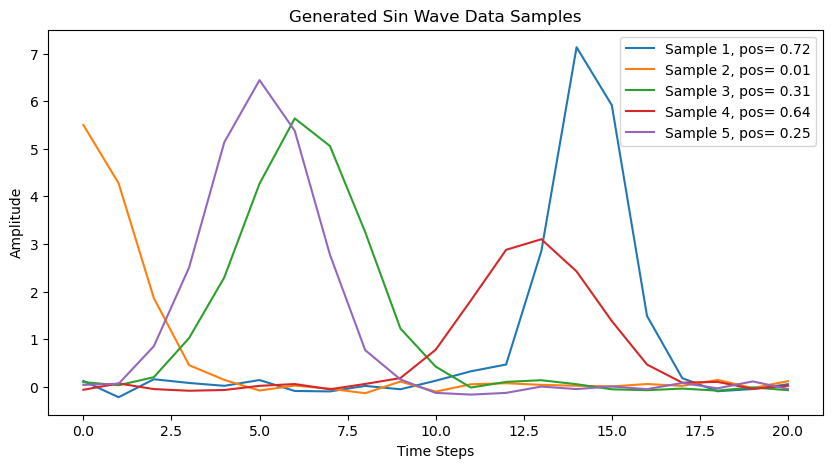

In [ ]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, pos= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

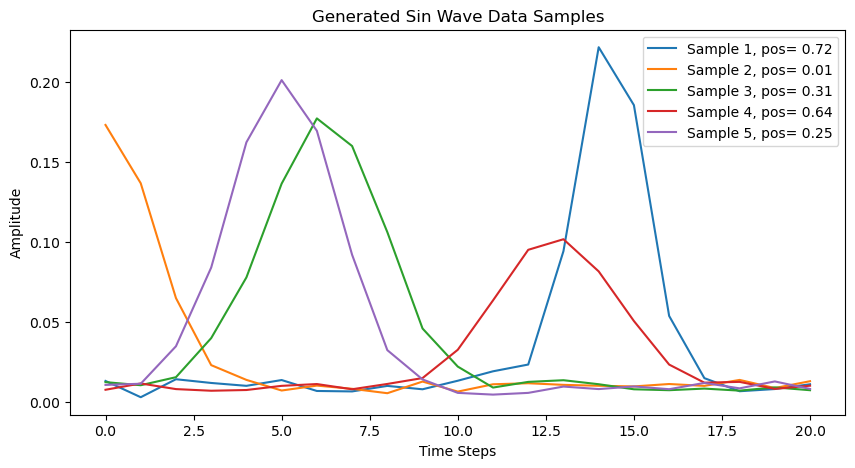

In [ ]:
# normalize data to [0, 1]
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, pos= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [ ]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 5),  # =1D kernel size = number of qubits
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0), # not implemented
    "input_length": seq_len,
    "stride": 4,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 7.0
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_2"
)

# set some parameters to not require gradients. They didn't change much last time
# NAHEA_CNN._parameters["positions"].requires_grad = False
NAHEA_CNN._parameters["local_pulses_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_2"].requires_grad = False

Final FC NN: Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)
Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [ ]:
y_train.shape

(150, 3)

In [ ]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
print(f"{NAHEA_CNN.parameters()}")
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size, 0], dtype=torch.float64 # only predict peak positions
        )
        batch_out = [NAHEA_CNN.forward(xx, dist_grad=True) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1} loss: {loss.item():.4f}, "
            f"RMSE: {np.sqrt(loss.item()):.4f}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss: {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.],
        [ 14.,   0.]], requires_grad=True), 'local_pulses_omega_1': tensor([0.5000, 1.0000, 1.5000, 1.0000, 0.5000], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(1., requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.5000, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([0.0497, 0.0451, 0.0448, 0.0617, 0.0243, 0.0288, 0.0600, 0.0759, 0.0435,
        0.0286, 0.0462, 0.0116, 0.0417, 0.0654, 0.0285, 0.0353, 0.0701, 0.0320,
        0.0225, 0.0465, 0.0471, 0.0387, 0.0733, 0.0405, 0.0145, 0.0529, 0.0192,
        0.0575, 0.0486, 0.0463, 0.0642, 0.0253], dtype=torch.float64,
       requires_grad=True), '0.weight': Parameter containing:
tensor([[-0.0870, 

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.3885, RMSE: 0.6233
Batch 2 loss: 0.2651, RMSE: 0.5149
Batch 3 loss: 0.2671, RMSE: 0.5168
Batch 4 loss: 0.3481, RMSE: 0.5900
Batch 5 loss: 0.2300, RMSE: 0.4796
Batch 6 loss: 0.2514, RMSE: 0.5014
Batch 7 loss: 0.2499, RMSE: 0.4999
Batch 8 loss: 0.2248, RMSE: 0.4741
Batch 9 loss: 0.2456, RMSE: 0.4956
Batch 10 loss: 0.3445, RMSE: 0.5869
Epoch 1 train loss: 0.28148678983906905


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.1630, RMSE: 0.4037
Batch 2 loss: 0.2730, RMSE: 0.5225
Batch 3 loss: 0.1909, RMSE: 0.4369
Batch 4 loss: 0.2060, RMSE: 0.4539
Batch 5 loss: 0.0905, RMSE: 0.3008
Batch 6 loss: 0.1387, RMSE: 0.3725
Batch 7 loss: 0.1285, RMSE: 0.3585
Batch 8 loss: 0.0814, RMSE: 0.2853
Batch 9 loss: 0.1166, RMSE: 0.3415
Batch 10 loss: 0.0684, RMSE: 0.2615
Epoch 2 train loss: 0.1457005041183319


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0808, RMSE: 0.2842
Batch 2 loss: 0.0548, RMSE: 0.2342
Batch 3 loss: 0.0755, RMSE: 0.2748
Batch 4 loss: 0.1261, RMSE: 0.3551
Batch 5 loss: 0.0951, RMSE: 0.3083
Batch 6 loss: 0.1099, RMSE: 0.3315
Batch 7 loss: 0.0847, RMSE: 0.2910
Batch 8 loss: 0.0960, RMSE: 0.3099
Batch 9 loss: 0.0500, RMSE: 0.2235
Batch 10 loss: 0.1300, RMSE: 0.3606
Epoch 3 train loss: 0.09028795034091174


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.1112, RMSE: 0.3335
Batch 2 loss: 0.0874, RMSE: 0.2957
Batch 3 loss: 0.0823, RMSE: 0.2869
Batch 4 loss: 0.0890, RMSE: 0.2984
Batch 5 loss: 0.0892, RMSE: 0.2987
Batch 6 loss: 0.0589, RMSE: 0.2428
Batch 7 loss: 0.1054, RMSE: 0.3246
Batch 8 loss: 0.0498, RMSE: 0.2231
Batch 9 loss: 0.0501, RMSE: 0.2237
Batch 10 loss: 0.0928, RMSE: 0.3047
Epoch 4 train loss: 0.08161204354109994


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0776, RMSE: 0.2786
Batch 2 loss: 0.0637, RMSE: 0.2524
Batch 3 loss: 0.0465, RMSE: 0.2156
Batch 4 loss: 0.0866, RMSE: 0.2943
Batch 5 loss: 0.0690, RMSE: 0.2627
Batch 6 loss: 0.0997, RMSE: 0.3158
Batch 7 loss: 0.0710, RMSE: 0.2664
Batch 8 loss: 0.0823, RMSE: 0.2868
Batch 9 loss: 0.1008, RMSE: 0.3174
Batch 10 loss: 0.1567, RMSE: 0.3958
Epoch 5 train loss: 0.08537971554237278


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0442, RMSE: 0.2101
Batch 2 loss: 0.1187, RMSE: 0.3445
Batch 3 loss: 0.0761, RMSE: 0.2758
Batch 4 loss: 0.0653, RMSE: 0.2556
Batch 5 loss: 0.0530, RMSE: 0.2302
Batch 6 loss: 0.0712, RMSE: 0.2668
Batch 7 loss: 0.0912, RMSE: 0.3019
Batch 8 loss: 0.0902, RMSE: 0.3004
Batch 9 loss: 0.0872, RMSE: 0.2953
Batch 10 loss: 0.1132, RMSE: 0.3365
Epoch 6 train loss: 0.0810249348949926


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0545, RMSE: 0.2335
Batch 2 loss: 0.0646, RMSE: 0.2541
Batch 3 loss: 0.0626, RMSE: 0.2501
Batch 4 loss: 0.1197, RMSE: 0.3460
Batch 5 loss: 0.0970, RMSE: 0.3115
Batch 6 loss: 0.0600, RMSE: 0.2450
Batch 7 loss: 0.0866, RMSE: 0.2943
Batch 8 loss: 0.0470, RMSE: 0.2169
Batch 9 loss: 0.0802, RMSE: 0.2832
Batch 10 loss: 0.0747, RMSE: 0.2732
Epoch 7 train loss: 0.07469720157830773


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0540, RMSE: 0.2324
Batch 2 loss: 0.0369, RMSE: 0.1921
Batch 3 loss: 0.0770, RMSE: 0.2775
Batch 4 loss: 0.0525, RMSE: 0.2292
Batch 5 loss: 0.0623, RMSE: 0.2497
Batch 6 loss: 0.1071, RMSE: 0.3272
Batch 7 loss: 0.0335, RMSE: 0.1831
Batch 8 loss: 0.0788, RMSE: 0.2807
Batch 9 loss: 0.0679, RMSE: 0.2605
Batch 10 loss: 0.0560, RMSE: 0.2366
Epoch 8 train loss: 0.06260383358715288


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0926, RMSE: 0.3042
Batch 2 loss: 0.0463, RMSE: 0.2151
Batch 3 loss: 0.0375, RMSE: 0.1937
Batch 4 loss: 0.0633, RMSE: 0.2515
Batch 5 loss: 0.0234, RMSE: 0.1529
Batch 6 loss: 0.0326, RMSE: 0.1805
Batch 7 loss: 0.0610, RMSE: 0.2470
Batch 8 loss: 0.0166, RMSE: 0.1289
Batch 9 loss: 0.0298, RMSE: 0.1727
Batch 10 loss: 0.0101, RMSE: 0.1006
Epoch 9 train loss: 0.041319075829670524


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0257, RMSE: 0.1602
Batch 2 loss: 0.0554, RMSE: 0.2354
Batch 3 loss: 0.0299, RMSE: 0.1730
Batch 4 loss: 0.0127, RMSE: 0.1128
Batch 5 loss: 0.0150, RMSE: 0.1225
Batch 6 loss: 0.0240, RMSE: 0.1549
Batch 7 loss: 0.0288, RMSE: 0.1697
Batch 8 loss: 0.0145, RMSE: 0.1205
Batch 9 loss: 0.0115, RMSE: 0.1071
Batch 10 loss: 0.0346, RMSE: 0.1861
Epoch 10 train loss: 0.02521541949126683


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0248, RMSE: 0.1574
Batch 2 loss: 0.0309, RMSE: 0.1759
Batch 3 loss: 0.0260, RMSE: 0.1613
Batch 4 loss: 0.0203, RMSE: 0.1424
Batch 5 loss: 0.0149, RMSE: 0.1219
Batch 6 loss: 0.0120, RMSE: 0.1097
Batch 7 loss: 0.0202, RMSE: 0.1420
Batch 8 loss: 0.0175, RMSE: 0.1322
Batch 9 loss: 0.0156, RMSE: 0.1250
Batch 10 loss: 0.0216, RMSE: 0.1470
Epoch 11 train loss: 0.02037880712344418


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0149, RMSE: 0.1219
Batch 2 loss: 0.0176, RMSE: 0.1328
Batch 3 loss: 0.0204, RMSE: 0.1430
Batch 4 loss: 0.0115, RMSE: 0.1071
Batch 5 loss: 0.0078, RMSE: 0.0881
Batch 6 loss: 0.0118, RMSE: 0.1085
Batch 7 loss: 0.0140, RMSE: 0.1182
Batch 8 loss: 0.0219, RMSE: 0.1480
Batch 9 loss: 0.0113, RMSE: 0.1064
Batch 10 loss: 0.0160, RMSE: 0.1266
Epoch 12 train loss: 0.014716749368373735


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0119, RMSE: 0.1092
Batch 2 loss: 0.0104, RMSE: 0.1022
Batch 3 loss: 0.0134, RMSE: 0.1159
Batch 4 loss: 0.0139, RMSE: 0.1179
Batch 5 loss: 0.0114, RMSE: 0.1069
Batch 6 loss: 0.0080, RMSE: 0.0895
Batch 7 loss: 0.0125, RMSE: 0.1117
Batch 8 loss: 0.0145, RMSE: 0.1203
Batch 9 loss: 0.0069, RMSE: 0.0830
Batch 10 loss: 0.0041, RMSE: 0.0643
Epoch 13 train loss: 0.0107128715922578


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0066, RMSE: 0.0810
Batch 2 loss: 0.0160, RMSE: 0.1265
Batch 3 loss: 0.0128, RMSE: 0.1130
Batch 4 loss: 0.0095, RMSE: 0.0975
Batch 5 loss: 0.0036, RMSE: 0.0598
Batch 6 loss: 0.0120, RMSE: 0.1094
Batch 7 loss: 0.0078, RMSE: 0.0885
Batch 8 loss: 0.0165, RMSE: 0.1284
Batch 9 loss: 0.0132, RMSE: 0.1149
Batch 10 loss: 0.0155, RMSE: 0.1245
Epoch 14 train loss: 0.011343430473124163


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0130, RMSE: 0.1141
Batch 2 loss: 0.0083, RMSE: 0.0912
Batch 3 loss: 0.0075, RMSE: 0.0865
Batch 4 loss: 0.0142, RMSE: 0.1191
Batch 5 loss: 0.0113, RMSE: 0.1064
Batch 6 loss: 0.0093, RMSE: 0.0966
Batch 7 loss: 0.0027, RMSE: 0.0515
Batch 8 loss: 0.0070, RMSE: 0.0839
Batch 9 loss: 0.0080, RMSE: 0.0896
Batch 10 loss: 0.0105, RMSE: 0.1027
Epoch 15 train loss: 0.009192519638742248


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0069, RMSE: 0.0832
Batch 2 loss: 0.0096, RMSE: 0.0980
Batch 3 loss: 0.0044, RMSE: 0.0660
Batch 4 loss: 0.0088, RMSE: 0.0937
Batch 5 loss: 0.0073, RMSE: 0.0852
Batch 6 loss: 0.0104, RMSE: 0.1018
Batch 7 loss: 0.0149, RMSE: 0.1219
Batch 8 loss: 0.0051, RMSE: 0.0715
Batch 9 loss: 0.0020, RMSE: 0.0452
Batch 10 loss: 0.0113, RMSE: 0.1063
Epoch 16 train loss: 0.00805707192471055


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0104, RMSE: 0.1020
Batch 2 loss: 0.0049, RMSE: 0.0701
Batch 3 loss: 0.0068, RMSE: 0.0827
Batch 4 loss: 0.0048, RMSE: 0.0694
Batch 5 loss: 0.0076, RMSE: 0.0873
Batch 6 loss: 0.0087, RMSE: 0.0932
Batch 7 loss: 0.0103, RMSE: 0.1017
Batch 8 loss: 0.0064, RMSE: 0.0800
Batch 9 loss: 0.0026, RMSE: 0.0507
Batch 10 loss: 0.0128, RMSE: 0.1133
Epoch 17 train loss: 0.007544209294268545


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0061, RMSE: 0.0779
Batch 2 loss: 0.0132, RMSE: 0.1149
Batch 3 loss: 0.0031, RMSE: 0.0558
Batch 4 loss: 0.0070, RMSE: 0.0836
Batch 5 loss: 0.0071, RMSE: 0.0843
Batch 6 loss: 0.0076, RMSE: 0.0874
Batch 7 loss: 0.0072, RMSE: 0.0847
Batch 8 loss: 0.0068, RMSE: 0.0826
Batch 9 loss: 0.0021, RMSE: 0.0458
Batch 10 loss: 0.0037, RMSE: 0.0608
Epoch 18 train loss: 0.006391733689599895


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0082, RMSE: 0.0908
Batch 2 loss: 0.0016, RMSE: 0.0398
Batch 3 loss: 0.0066, RMSE: 0.0812
Batch 4 loss: 0.0068, RMSE: 0.0824
Batch 5 loss: 0.0069, RMSE: 0.0830
Batch 6 loss: 0.0032, RMSE: 0.0570
Batch 7 loss: 0.0050, RMSE: 0.0708
Batch 8 loss: 0.0111, RMSE: 0.1054
Batch 9 loss: 0.0050, RMSE: 0.0709
Batch 10 loss: 0.0070, RMSE: 0.0837
Epoch 19 train loss: 0.006149586048614724


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0043, RMSE: 0.0652
Batch 2 loss: 0.0031, RMSE: 0.0557
Batch 3 loss: 0.0052, RMSE: 0.0720
Batch 4 loss: 0.0064, RMSE: 0.0801
Batch 5 loss: 0.0072, RMSE: 0.0847
Batch 6 loss: 0.0012, RMSE: 0.0345
Batch 7 loss: 0.0025, RMSE: 0.0501
Batch 8 loss: 0.0057, RMSE: 0.0755
Batch 9 loss: 0.0074, RMSE: 0.0860
Batch 10 loss: 0.0060, RMSE: 0.0776
Epoch 20 train loss: 0.004893554931924098
Final loss: 0.006023586870504028
Final loss (RMSE): 0.077611770180199


In [ ]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in tqdm(range(len(X_test))):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test[:,0], dtype=torch.float64)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

  0%|          | 0/500 [00:00<?, ?it/s]

Test loss MSE: 0.010638305934432319
RMSE: 0.10314216370831242
final parameters:
{'positions': tensor([[-13.9467,   0.0000],
        [ -7.0604,   0.0000],
        [ -0.0848,   0.0000],
        [  7.0057,   0.0000],
        [ 13.9203,   0.0000]], requires_grad=True), 'local_pulses_omega_1': tensor([0.3564, 0.7498, 1.3599, 1.0023, 0.7247], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(1.0424, requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.5705, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.2001,  0.1755, -0.0838,  0.3167, -0.0280,  0.3701,  0.1500,  0.0606,
         0.0780, -0.1023, -0.0668,  0.2896,  0.1820, -0.3822, -0.2829,  0.2933,
        -0.0074,  0.4116,  0.0412, -0.0868,  0.5062,  0.0790, -0.3330, -0.4898,
         0.0993,  0.4485, 

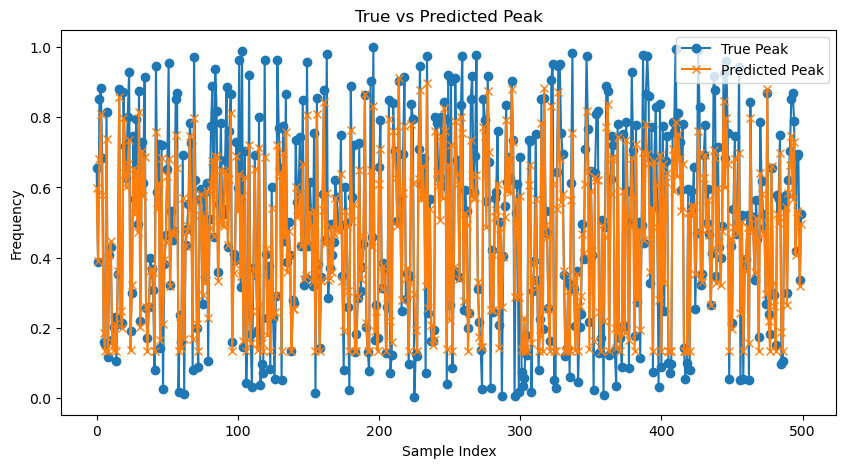

In [ ]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Peak", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Peak", marker='x')
plt.title("True vs Predicted Peak")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

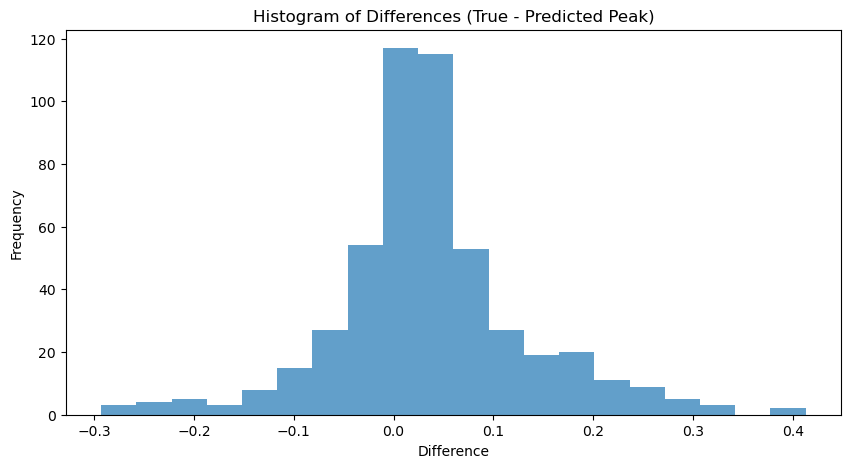

In [ ]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Peak)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

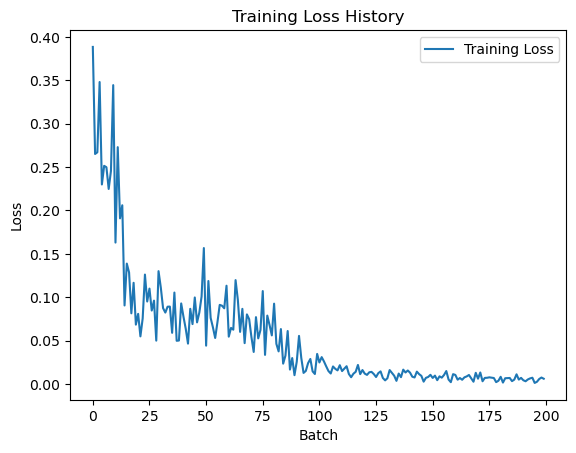

In [ ]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [ ]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [ ]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

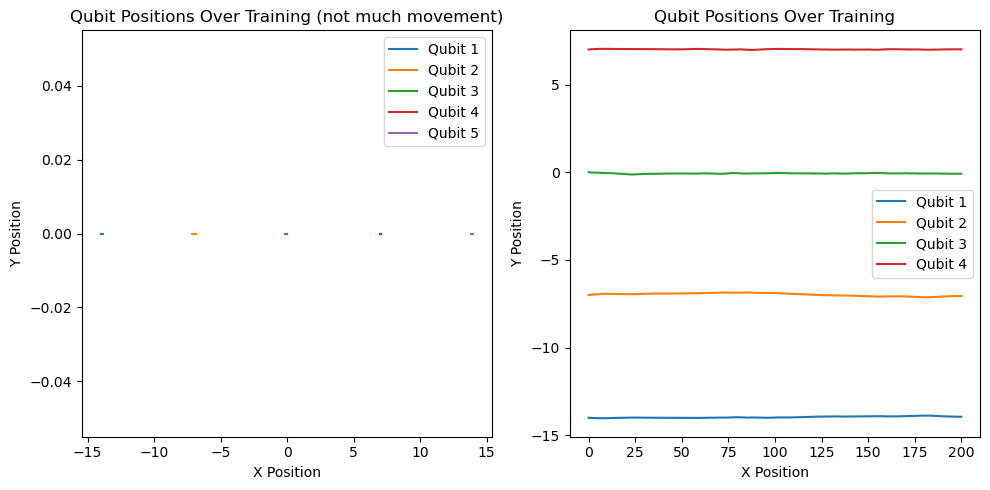

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (not much movement)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
# plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

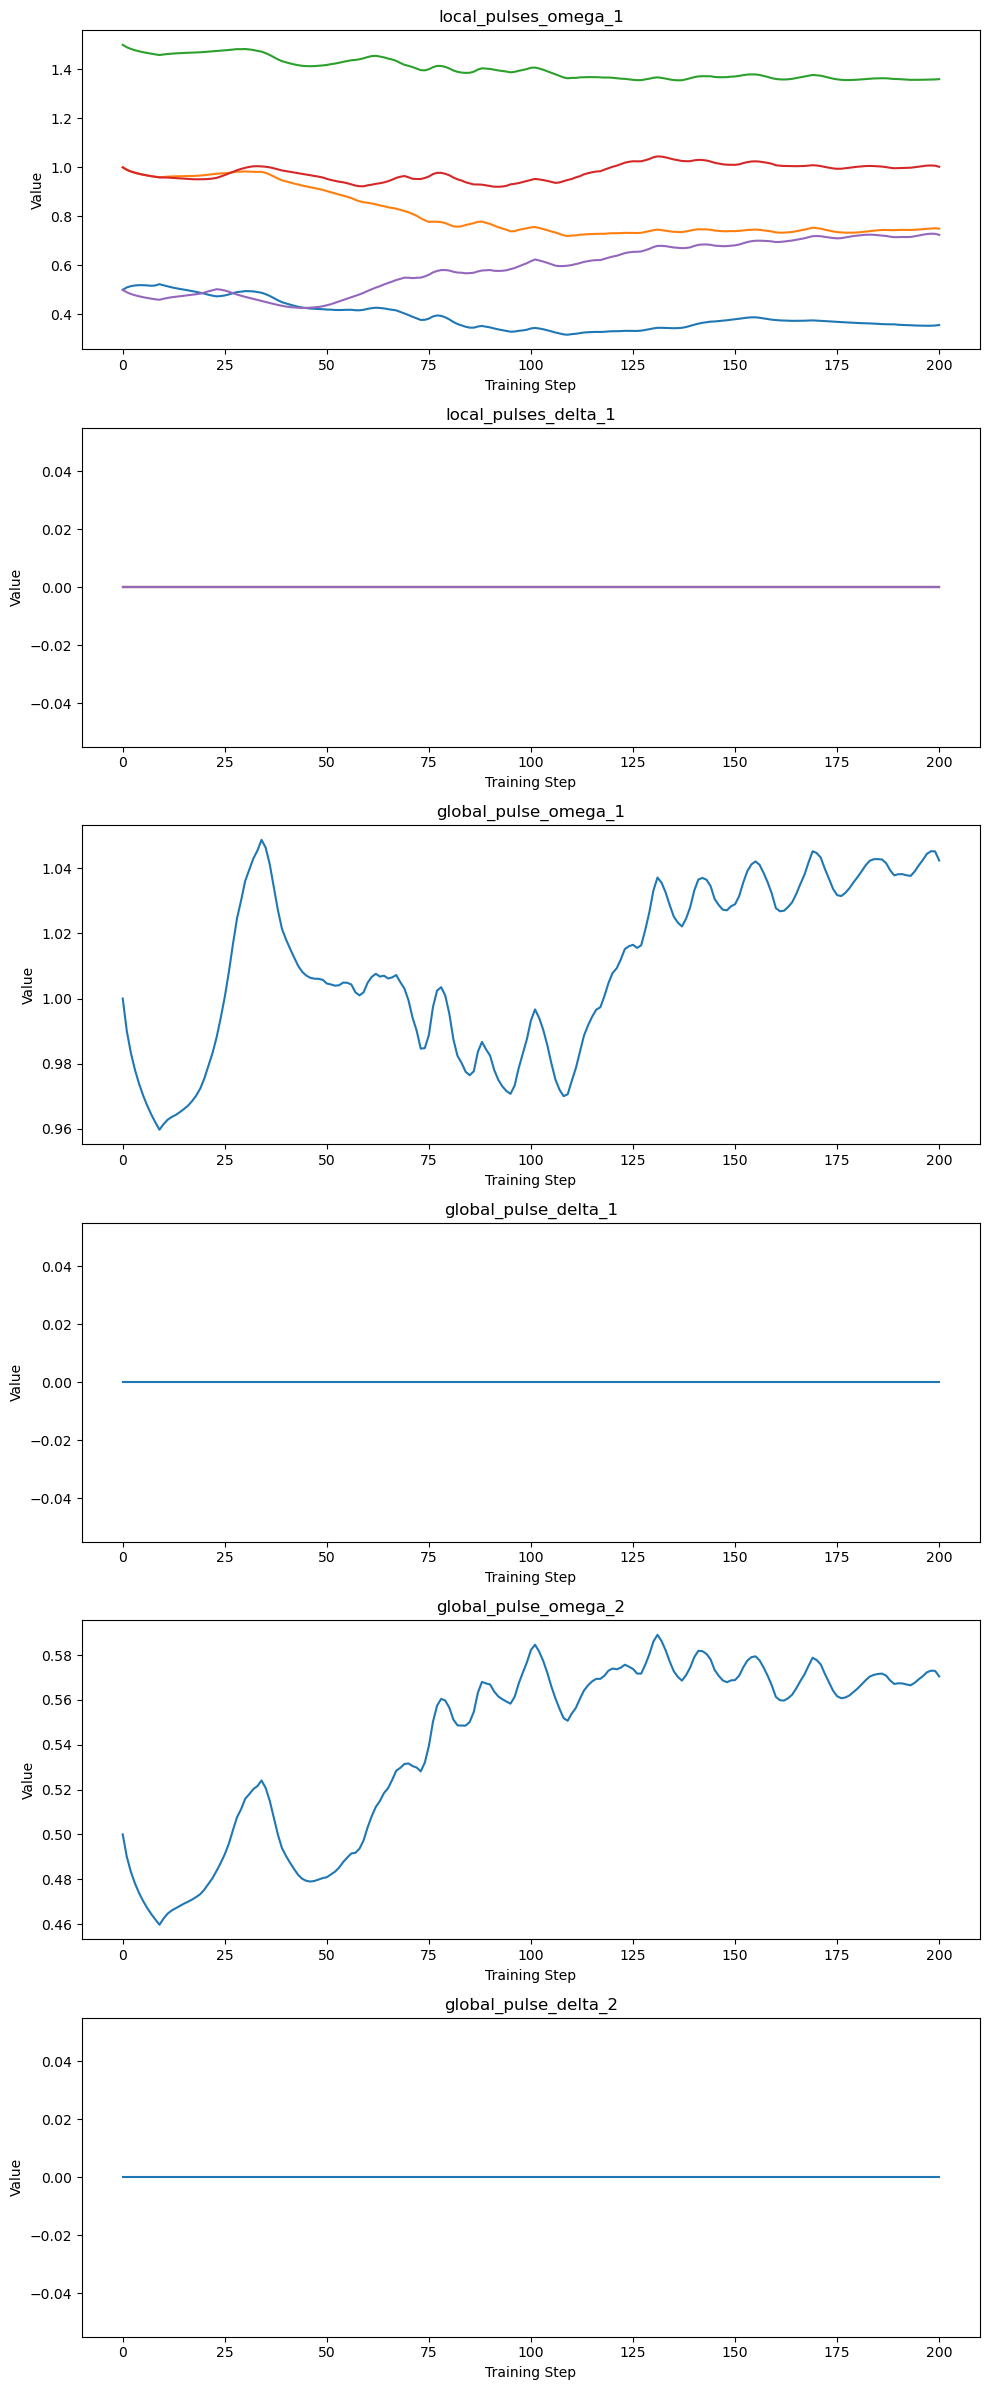

In [ ]:
plot_keys = ['local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

In [ ]:
import pickle

# number of learned parameters, i.e. with require_grad=True
NAHEA_CNN.train()
# number of parameters
n_params = sum(v.numel() for p, v in NAHEA_CNN.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/NAHEA_CNN_GaussPeak_dist_grad_true_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

Number of trainable parameters: 170
